# <center>ASL Recognition Model</center>

### Initialization

In [ ]:
import zipfile

# give permissions to kaggle API
! pip install kaggle
! mkdir /root/.kaggle
! cp kaggle.json /root/.kaggle
! chmod 600 /root/.kaggle/kaggle.json

mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [ ]:
# download dataset from kaggle to colab
! kaggle datasets download -d grassknoted/asl-alphabet

# extract the content of the zipped file
zip_ref = zipfile.ZipFile('asl-alphabet.zip', 'r')
zip_ref.extractall('/content/')
zip_ref.close()

100% 1.02G/1.03G [00:41<00:00, 30.8MB/s]
100% 1.03G/1.03G [00:41<00:00, 26.4MB/s]


In [ ]:
# rename the folder from 'American' to 'dataset' for ease of use
! rm -r /content/asl-alphabet.zip
! rm -r /content/kaggle.json

### Modules & Libraries

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.image as mimg

from scipy import stats
from sklearn.manifold import TSNE
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix


import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import VGG16, InceptionV3, ResNet50V2, DenseNet121
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import load_model, Model
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.layers import Dense, Conv2D, Dropout, Flatten, MaxPool2D, Activation, GlobalAveragePooling2D, BatchNormalization

import os
import cv2
import glob
import pickle
import random
import warnings
from google.colab import drive
from google.colab import files


# drive.mount('/content/gdrive')
warnings.filterwarnings('ignore')
%matplotlib inline

### Exploratory Data Analysis

In [ ]:
batch_size = 32
img_height = 128
img_width = 128
epochs = 30
num_classes = 27
img_channels = 3

In [ ]:
# Define the path to the main folder

! rm -r /content/asl_alphabet_train/asl_alphabet_train/del
! rm -r /content/asl_alphabet_train/asl_alphabet_train/nothing

main_folder_path = '/content/asl_alphabet_train/asl_alphabet_train/'


# Get a list of subfolders within the main folder
subfolders = os.listdir(main_folder_path)

#### Visualization of image from each class

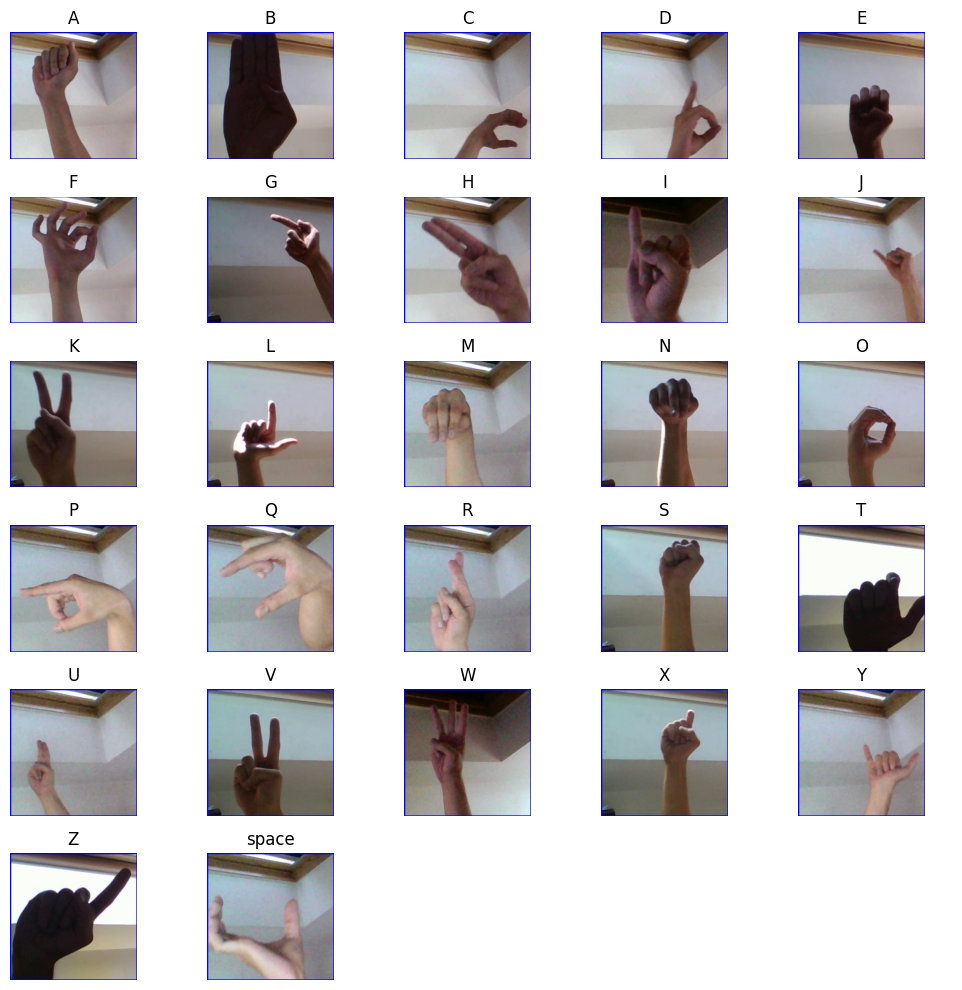

In [ ]:
categories = {}
label = []
count = []

# Create a figure to display the images
rows = 6
columns = 5
fig, axs = plt.subplots(rows, columns, figsize=(10, 10))
ax = axs.ravel()

# Iterate through each subfolder and display the first image
for index, subfolder in enumerate(sorted(subfolders)):
    plt.xticks([])
    plt.yticks([])

    categories[index] = subfolder

    # print('subfolder', subfolder, i)
    subfolder_path = os.path.join(main_folder_path, subfolder)
    image_files = os.listdir(subfolder_path)

    count.append(len(image_files))
    label.append(subfolder)

    # Load the first image in the subfolder
    image_path = os.path.join(subfolder_path, image_files[0])
    img = mimg.imread(image_path)

    # Display the image using plt.imshow
    ax[index].imshow(img)
    ax[index].set_title(subfolder)
    ax[index].axis('off')

ax[index+1].set_axis_off()
ax[index+2].set_axis_off()
ax[index+3].set_axis_off()



# Adjust the layout and display the figure
plt.tight_layout()
plt.show()

df = pd.DataFrame({'Label': label, 'Count': count})

#### Visualization of number of images in each class

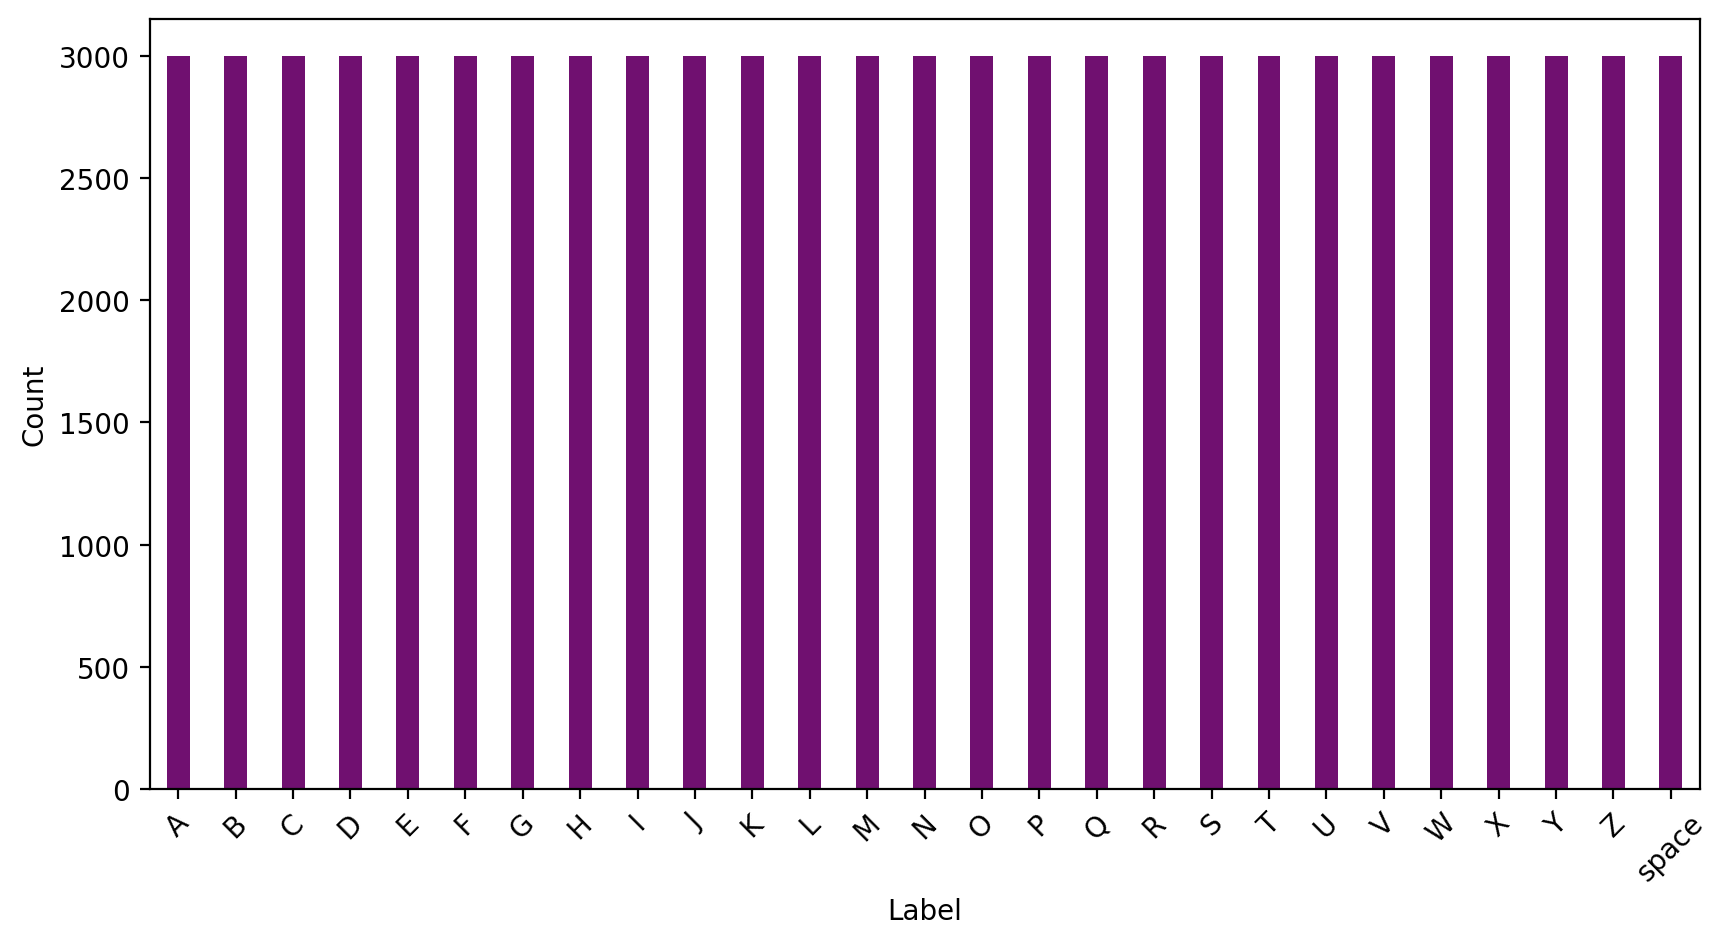

In [ ]:
plt.figure(figsize=(10, 5), dpi=200)
# plt.title('Class distribution in Dataset',fontsize=15)

sns.barplot(data=df, x='Label', y='Count', width=0.4, color='purple')

plt.xticks(rotation = 45)
plt.show()

In [ ]:
df['Count'].min(), df['Count'].max()

(3000, 3000)

Since there are 3000 images in each clas, we can conclude that the dataset is balanced.

In [ ]:
categories

{0: 'A',
 1: 'B',
 2: 'C',
 3: 'D',
 4: 'E',
 5: 'F',
 6: 'G',
 7: 'H',
 8: 'I',
 9: 'J',
 10: 'K',
 11: 'L',
 12: 'M',
 13: 'N',
 14: 'O',
 15: 'P',
 16: 'Q',
 17: 'R',
 18: 'S',
 19: 'T',
 20: 'U',
 21: 'V',
 22: 'W',
 23: 'X',
 24: 'Y',
 25: 'Z',
 26: 'space'}

#### Distribution of dimension of the images

In [ ]:
width_dim = []
height_dim = []

def get_dimension():
    sub_dataset_path = f'/content/asl_alphabet_train/asl_alphabet_train'
    letters = os.listdir(sub_dataset_path)

    for letter in letters:
        letter_path = os.path.join(sub_dataset_path, letter)

        for image in os.listdir(letter_path):

            image_path = os.path.join(letter_path, image)
            img = mimg.imread(image_path)
            d1, d2, colors = img.shape

            width_dim.append(d1)
            height_dim.append(d2)

get_dimension()

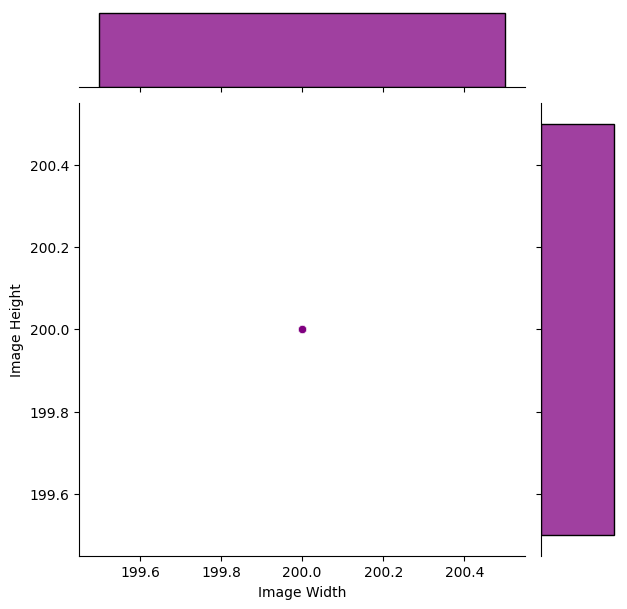

In [ ]:
sns.jointplot(x=width_dim, y=height_dim, color='purple')
plt.xlabel("Image Width")
plt.ylabel("Image Height")
plt.show()

In [ ]:
stats.mode(width_dim), stats.mode(height_dim), 3

(ModeResult(mode=200, count=81000), ModeResult(mode=200, count=81000), 3)

The dimension of each image in the dataset is 200x200.

In [ ]:
image_shape = (128, 128, 3)
print(200*200*3)
print(128*128*3)

120000
49152


### Data Preprocessing

In [ ]:
# Create dataframe
labels = list(categories.values())

list_path = []
list_labels = []
for label in labels:
    label_path = os.path.join(main_folder_path, label, "*")
    image_files = glob.glob(label_path)

    sign_label = [label] * len(image_files)


    list_path.extend(image_files)
    list_labels.extend(sign_label)

dataframe = pd.DataFrame({
    "image_path": list_path,
    "label": list_labels
})

# dataframe

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    dataframe["image_path"],
    dataframe["label"],
    test_size=0.15,
    random_state=2024,
    shuffle=True,
    stratify = dataframe["label"]
)

train_df = pd.DataFrame({
    "image_path": X_train,
    "label": y_train
})

X_train, X_val, y_train, y_val = train_test_split(
    train_df["image_path"], train_df["label"],
    test_size=0.20,
    random_state=2024,
    shuffle=True,
    stratify=train_df["label"]
)

train_df = pd.DataFrame({
    "image_path": X_train,
    "label": y_train
})
val_df = pd.DataFrame({
    "image_path": X_val,
    "label": y_val
})
test_df = pd.DataFrame({
    "image_path": X_test,
    "label": y_test
})

In [ ]:
datagen = image.ImageDataGenerator(rescale=1/255.,)
# Training Dataset
train_gen = datagen.flow_from_dataframe(
    train_df,
    directory="./",
    x_col="image_path",
    y_col="label",
    class_mode="categorical",
    batch_size=batch_size,
    target_size=(img_height, img_width),
)

# Validation Dataset
val_gen = datagen.flow_from_dataframe(
    val_df,
    directory="./",
    x_col="image_path",
    y_col="label",
    class_mode="categorical",
    batch_size=batch_size,
    target_size=(img_height, img_width),
)

# Testing Dataset
test_gen = datagen.flow_from_dataframe(
    test_df,
    directory="./",
    x_col="image_path",
    y_col="label",
    class_mode="categorical",
    batch_size=1,
    target_size=(img_height, img_width),
    shuffle=False
)

Found 55080 validated image filenames belonging to 27 classes.
Found 13770 validated image filenames belonging to 27 classes.
Found 12150 validated image filenames belonging to 27 classes.


### Model Training

In [ ]:
early_stopping = EarlyStopping(monitor='val_loss',
                              min_delta=0.001,
                              patience=5,
                              restore_best_weights=True,
                              verbose=True)

reduce_learning_rate = ReduceLROnPlateau(monitor='val_accuracy',
                                        patience=2,
                                        factor=0.5,
                                        verbose=True)

checkpoint = ModelCheckpoint('best_weights.h5', save_best_only=True, monitor='val_accuracy', mode='max')

**VGG16**

In [ ]:
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(img_height, img_width, img_channels))

model = Sequential()
model.add(base_model)
model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(27, activation='softmax'))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 4, 4, 512)         14714688  
                                                                 
 flatten_1 (Flatten)         (None, 8192)              0         
                                                                 
 dense_3 (Dense)             (None, 512)               4194816   
                                                                 
 dropout_2 (Dropout)         (None, 512)               0         
                                                                 
 dense_4 (Dense)             (None, 512)               262656    
                                                                 
 dropout_3 (Dropout)         (None, 512)               0         
                                                                 
 dense_5 (Dense)             (None, 27)                1

In [ ]:
# Load VGG16 model and modify for ASL recognition
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(img_height, img_width, img_channels))

for layer in base_model.layers:
    layer.trainable = False

x = base_model.output
x = Flatten()(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(27, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)

display(model.summary())
# display(tf.keras.utils.plot_model(model, to_file='vgg16.png', show_shapes=True))

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 128, 128, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 128, 128, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 64, 64, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 64, 64, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 64, 64, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 32, 32, 128)       0     

None

In [ ]:
# Compile and train the model
model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
# Train the Model
model.fit(
    train_gen,
    steps_per_epoch=train_gen.samples // batch_size,
    epochs=epochs,
    validation_data=val_gen,
    validation_steps=val_gen.samples // batch_size,
    callbacks=[checkpoint, early_stopping, reduce_learning_rate],
    verbose=True
)

## Model Evaluation

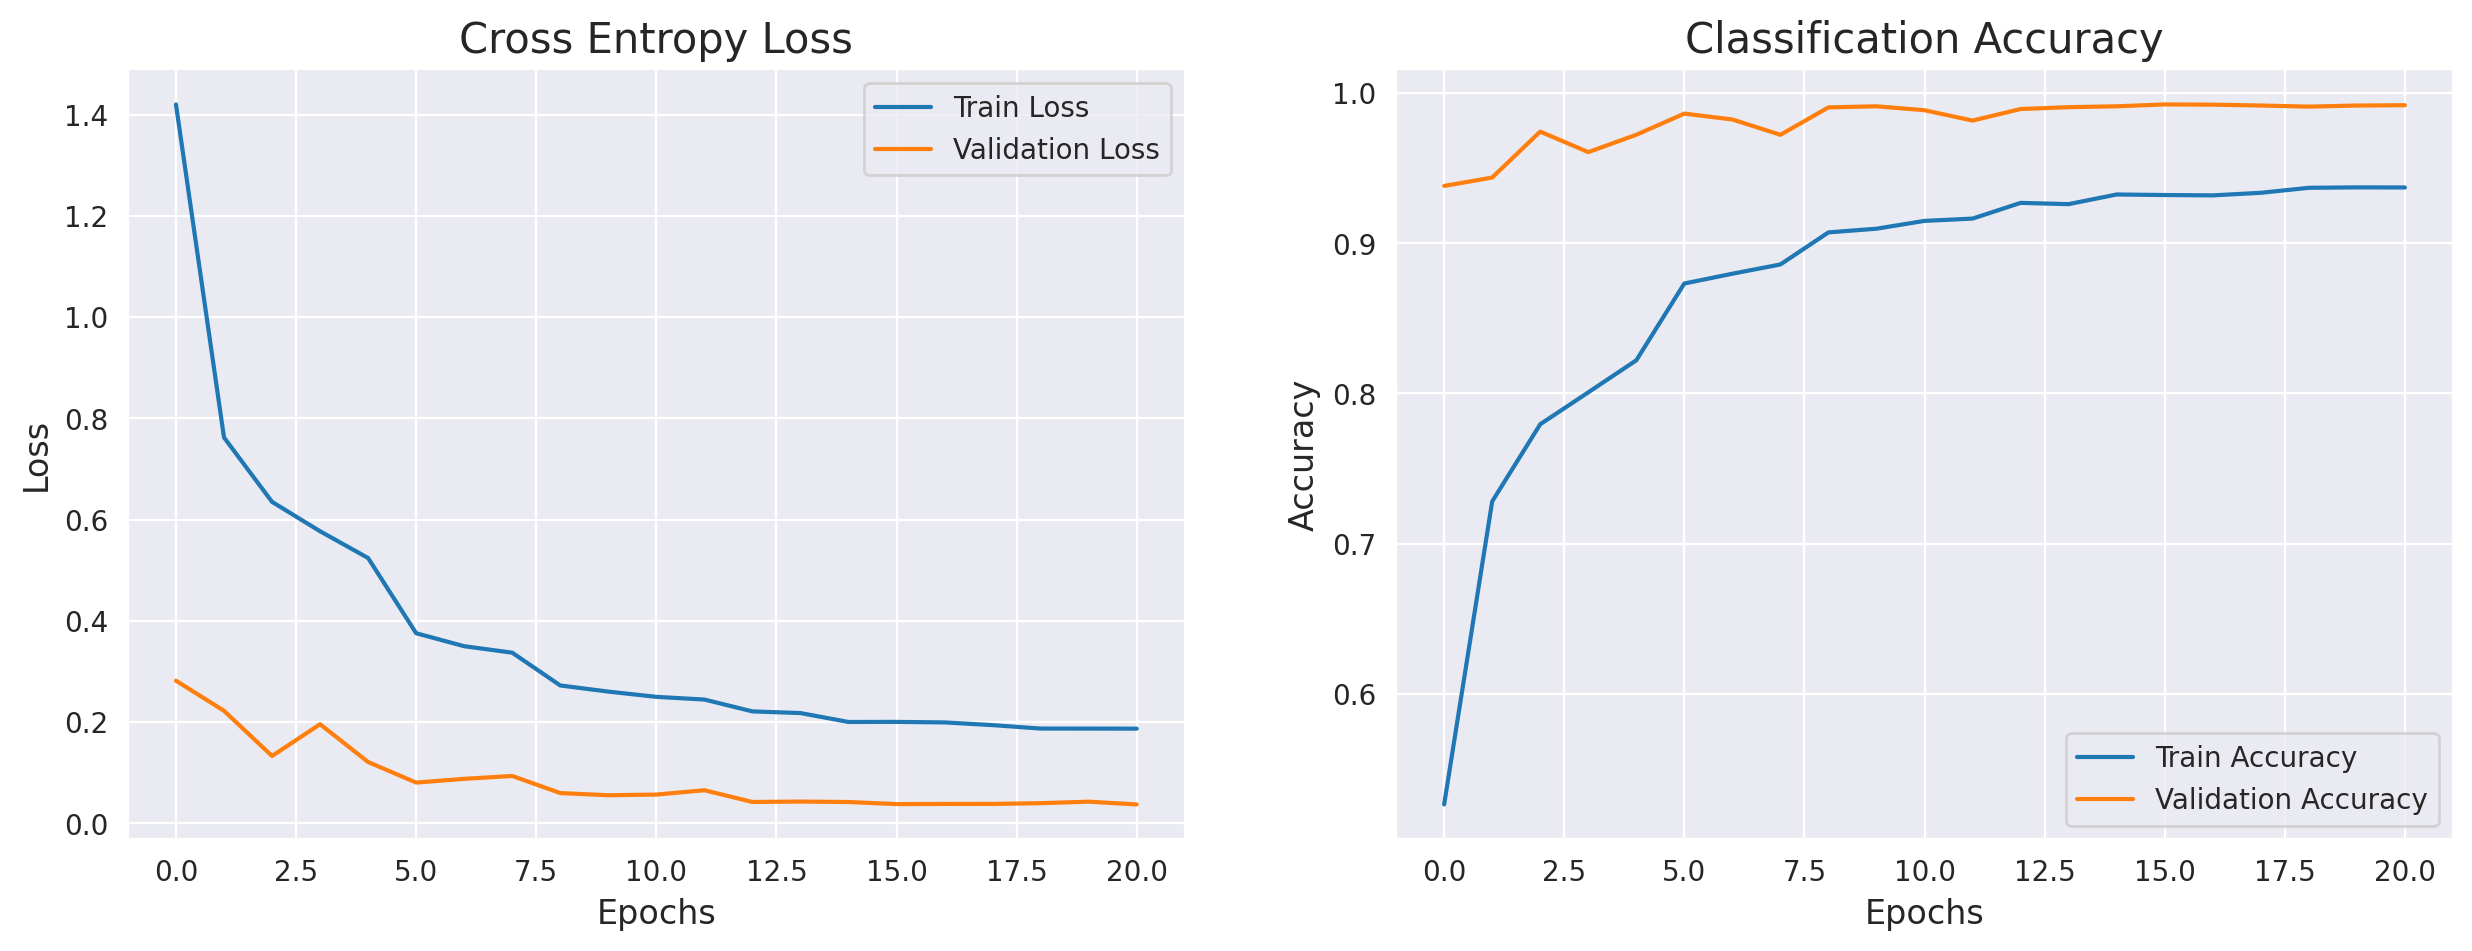

In [ ]:
metrics = pd.DataFrame(model.history.history)

plt.figure(figsize=(15,5),dpi=200)
sns.set_style('darkgrid')

plt.subplot(121)
plt.title('Cross Entropy Loss',fontsize=15)
plt.xlabel('Epochs',fontsize=12)
plt.ylabel('Loss',fontsize=12)
plt.plot(metrics['loss'], label='Train Loss')
plt.plot(metrics['val_loss'], label='Validation Loss')
plt.legend()

plt.subplot(122)
plt.title('Classification Accuracy',fontsize=15)
plt.xlabel('Epochs',fontsize=12)
plt.ylabel('Accuracy',fontsize=12)
plt.plot(metrics['accuracy'], label='Train Accuracy')
plt.plot(metrics['val_accuracy'], label='Validation Accuracy')
plt.legend()

plt.show()

In [ ]:
# Evaluate test dataset
loss, acc = model.evaluate(test_gen, verbose=False)

print('The accuracy of the model for testing data is:', acc*100)
print('The Loss of the model for testing data is:', loss)

The accuracy of the model for testing data is: 99.34156537055969
The Loss of the model for testing data is: 0.03528153896331787


In [ ]:
predicted_class = model.predict(test_gen, verbose=False)
predicted_class = np.argmax(predicted_class, axis=1)
actual_class = test_gen.labels

correct = np.nonzero(predicted_class == actual_class)[0]
incorrect = np.nonzero(predicted_class != actual_class)[0]

print("Correct predicted classes:", correct.shape[0])
print("Incorrect predicted classes:", incorrect.shape[0])

Correct predicted classes: 12070
Incorrect predicted classes: 80


In [ ]:
print(classification_report(actual_class, predicted_class,
                            target_names=categories.values()))

              precision    recall  f1-score   support

           A       1.00      1.00      1.00       450
           B       1.00      0.96      0.98       450
           C       1.00      1.00      1.00       450
           D       1.00      1.00      1.00       450
           E       0.97      1.00      0.98       450
           F       1.00      1.00      1.00       450
           G       0.96      1.00      0.98       450
           H       1.00      0.95      0.98       450
           I       1.00      1.00      1.00       450
           J       1.00      1.00      1.00       450
           K       1.00      1.00      1.00       450
           L       1.00      1.00      1.00       450
           M       0.98      1.00      0.99       450
           N       1.00      0.98      0.99       450
           O       1.00      1.00      1.00       450
           P       1.00      1.00      1.00       450
           Q       1.00      1.00      1.00       450
           R       1.00    

In [ ]:
con_matrix = tf.math.confusion_matrix(
        labels=actual_class,
        predictions=predicted_class,
        num_classes=27)

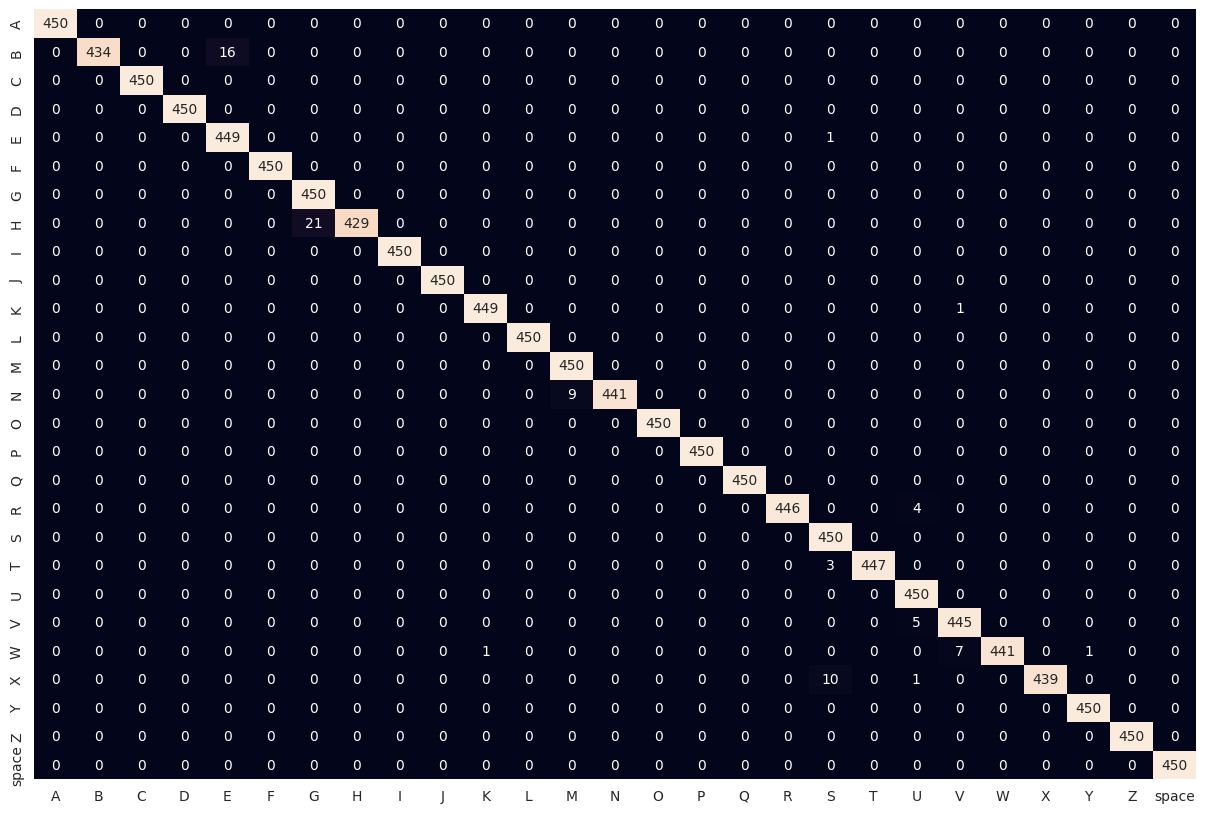

In [ ]:
plt.figure(figsize=(15,10))
sns.heatmap(con_matrix, annot=True, fmt='g', cbar=False, xticklabels=categories.values(), yticklabels=categories.values())
plt.show()

In [ ]:
test_images = '/content/asl_alphabet_test/asl_alphabet_test'

for i in os.listdir(test_images):
  img = os.path.join(test_images, i)
  print(f'Image: {i}', end='\t\t')
  img = cv2.imread(img, cv2.IMREAD_COLOR)
  img = cv2.resize(img, (128, 128))

  img = image.img_to_array(img)

  img = img / 255.0
  img = np.expand_dims(img, axis=0)

  predict = model.predict(img, verbose=False)
  predict_class = np.argmax(predict, axis=1)

  print("Prediction: ", categories[tuple(predict_class)[0]], end='\n\n')

Image: I_test.jpg		Prediction:  I

Image: D_test.jpg		Prediction:  D

Image: G_test.jpg		Prediction:  G

Image: S_test.jpg		Prediction:  S

Image: A_test.jpg		Prediction:  S

Image: K_test.jpg		Prediction:  K

Image: H_test.jpg		Prediction:  H

Image: Q_test.jpg		Prediction:  Q

Image: N_test.jpg		Prediction:  N

Image: T_test.jpg		Prediction:  T

Image: Y_test.jpg		Prediction:  Y

Image: P_test.jpg		Prediction:  P

Image: Z_test.jpg		Prediction:  Z

Image: M_test.jpg		Prediction:  M

Image: U_test.jpg		Prediction:  U

Image: R_test.jpg		Prediction:  R

Image: O_test.jpg		Prediction:  O

Image: B_test.jpg		Prediction:  B

Image: E_test.jpg		Prediction:  E

Image: L_test.jpg		Prediction:  L

Image: J_test.jpg		Prediction:  J

Image: V_test.jpg		Prediction:  V

Image: C_test.jpg		Prediction:  C

Image: W_test.jpg		Prediction:  W

Image: space_test.jpg		Prediction:  space

Image: X_test.jpg		Prediction:  X

Image: nothing_test.jpg		Prediction:  U

Image: F_test.jpg		Prediction:  F



## Save Model

In [ ]:
model.save('vgg16_model7.h5')
! cp vgg16_model7.h5 /content/gdrive/MyDrive/Models/
! cp /content/asl_vgg16_best_weights.h5 /content/gdrive/MyDrive/Models/
! ls /content/gdrive/MyDrive/Models/

vgg16_model7.h5


## Feature Extraction

In [ ]:
fine_tuned_model = load_model("asl_vgg16_best_weights.h5")

In [ ]:
dense_model = Model(inputs=fine_tuned_model.inputs, outputs=fine_tuned_model.layers[-3].output)
dense_model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 128, 128, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 128, 128, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 64, 64, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 64, 64, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 64, 64, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 32, 32, 128)       0   

In [ ]:
# Extract Features in Dense Layer
def dense_feature_prediction(img_path):
    img = image.load_img(img_path, target_size=(img_height, img_width))
    img = image.img_to_array(img)
    img = img / 255.
    img = np.expand_dims(img, axis=0)
    dense_feature = dense_model.predict(img, verbose=0)[0]
    return dense_feature

reduction_data = pd.DataFrame()
for label in labels:
    label_data = test_df[test_df["label"]==label][:100]
    reduction_data = reduction_data.append(label_data)

reduction_data = reduction_data.reset_index(drop=True)
display(reduction_data)

dense_features = reduction_data["image_path"].apply(dense_feature_prediction)
dense_features = pd.DataFrame.from_records(dense_features.values, index=dense_features.index)

,image_path,label
0,/content/asl_alphabet_train/asl_alphabet_train...,A
1,/content/asl_alphabet_train/asl_alphabet_train...,A
2,/content/asl_alphabet_train/asl_alphabet_train...,A
3,/content/asl_alphabet_train/asl_alphabet_train...,A
4,/content/asl_alphabet_train/asl_alphabet_train...,A
...,...,...
2695,/content/asl_alphabet_train/asl_alphabet_train...,space
2696,/content/asl_alphabet_train/asl_alphabet_train...,space
2697,/content/asl_alphabet_train/asl_alphabet_train...,space
2698,/content/asl_alphabet_train/asl_alphabet_train...,space


In [ ]:
# tSNE Dimensional Reduction
tsne = TSNE(n_components=2, verbose=1, random_state=0, angle=.99, init='pca')
tsne_features = tsne.fit_transform(dense_features)
tsne_features = pd.DataFrame(tsne_features, columns=["tsne_feat_0", "tsne_feat_1"])
reduction_data[["tsne_feat_0", "tsne_feat_1"]] = tsne_features
reduction_data

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 2700 samples in 0.004s...
[t-SNE] Computed neighbors for 2700 samples in 0.457s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2700
[t-SNE] Computed conditional probabilities for sample 2000 / 2700
[t-SNE] Computed conditional probabilities for sample 2700 / 2700
[t-SNE] Mean sigma: 3.010735
[t-SNE] KL divergence after 250 iterations with early exaggeration: 50.482216
[t-SNE] KL divergence after 1000 iterations: 0.470936


,image_path,label,tsne_feat_0,tsne_feat_1
0,/content/asl_alphabet_train/asl_alphabet_train...,A,-14.083920,12.890792
1,/content/asl_alphabet_train/asl_alphabet_train...,A,-15.287537,8.018493
2,/content/asl_alphabet_train/asl_alphabet_train...,A,-14.182034,12.836912
3,/content/asl_alphabet_train/asl_alphabet_train...,A,-17.126638,3.938916
4,/content/asl_alphabet_train/asl_alphabet_train...,A,-16.852747,5.038319
...,...,...,...,...
2695,/content/asl_alphabet_train/asl_alphabet_train...,space,19.685337,-9.626353
2696,/content/asl_alphabet_train/asl_alphabet_train...,space,22.038038,-10.693312
2697,/content/asl_alphabet_train/asl_alphabet_train...,space,18.850737,-9.229342
2698,/content/asl_alphabet_train/asl_alphabet_train...,space,20.541269,-11.272882


In [ ]:
reduction_data.to_csv('dataframe.csv')

In [ ]:
import plotly
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots

In [ ]:
# Scatter Plot
list_colors = ["#FF0000", "#00FF00", "#0000FF", "#FFFF00", "#FF00FF", "#00FFFF", "#FF4500", "#800080", "#32CD32", "#8B0000",
               "#000080", "#808000", "#FF6347", "#008080", "#FF1493", "#7FFF00", "#D2691E", "#9400D3", "#B22222", "#ADFF2F",
               "#ADD8E6", "#FF69B4", "#F0E68C", "#4682B4", "#9ACD32", "#800000", "#FFD700", "#20B2AA", "#A52A2A"
              ]
fig = px.scatter(
    reduction_data, x="tsne_feat_0", y="tsne_feat_1", color='label', color_discrete_sequence=list_colors
)

fig.update_traces(marker=dict(size=8),)

# Update Axes
fig.update_xaxes(title="", linecolor="Black", zeroline=False, mirror=True)
fig.update_yaxes(title="", linecolor="Black", zeroline=False, mirror=True)

# Update Layout
fig.update_layout(
    title_text="t-SNE Visualization", title_x=0.5,
    width=900, height=900,
    plot_bgcolor='White',
    coloraxis_showscale=False,
)

# Show
fig.show()

In [ ]:
fig.write_html('feat_ext.html')

**CNN**

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 124, 124, 32)      2432      
                                                                 
 activation (Activation)     (None, 124, 124, 32)      0         
                                                                 
 max_pooling2d (MaxPooling2  (None, 62, 62, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 60, 60, 64)        18496     
                                                                 
 activation_1 (Activation)   (None, 60, 60, 64)        0         
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 30, 30, 64)        0         
 g2D)                                                   

None

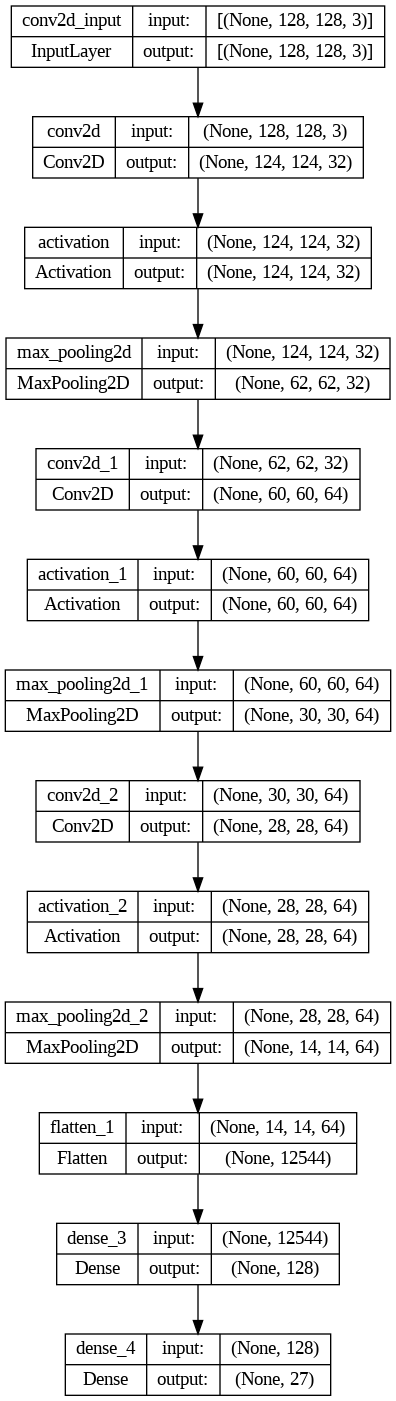

In [ ]:
cnn_model = Sequential()
cnn_model.add(Conv2D(32, (5, 5), input_shape=image_shape)) ##32 filters, 5x5 kernel, input shape is 128x128x3
cnn_model.add(Activation('relu')) ##activation function
cnn_model.add(MaxPool2D((2, 2))) ##pooling layer
cnn_model.add(Conv2D(64, (3, 3))) ##64 filters, 3x3 kernel
cnn_model.add(Activation('relu')) ##activation function
cnn_model.add(MaxPool2D((2, 2))) ##pooling layer
cnn_model.add(Conv2D(64, (3, 3))) ##64 filters, 3x3 kernel
cnn_model.add(Activation('relu')) ##activation function
cnn_model.add(MaxPool2D((2, 2))) ##pooling layer
cnn_model.add(Flatten()) ##flatten the data
cnn_model.add(Dense(128, activation='relu')) ##128 neurons, activation function
cnn_model.add(Dense(27, activation='softmax')) ##output layer, 27 neurons, activation function

display(cnn_model.summary())
display(tf.keras.utils.plot_model(cnn_model, to_file='cnn.png', show_shapes=True))

In [ ]:
# Compile and train the model
cnn_model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])
# Train the Model
cnn_model.fit(
    train_gen,
    steps_per_epoch=train_gen.samples // batch_size,
    epochs=epochs,
    validation_data=val_gen,
    validation_steps=val_gen.samples // batch_size,
    callbacks=[checkpoint, early_stopping, reduce_learning_rate],
    verbose=True
)

In [ ]:
cnn_model.save('cnn_model.h5')
! cp cnn_model.h5 /content/gdrive/MyDrive/Models/
! cp feat_ext.html /content/gdrive/MyDrive/Models/
! ls /content/gdrive/MyDrive/Models/

asl_vgg16_best_weights.h5  cnn_model.h5  feat_ext.html	vgg16_model7.h5


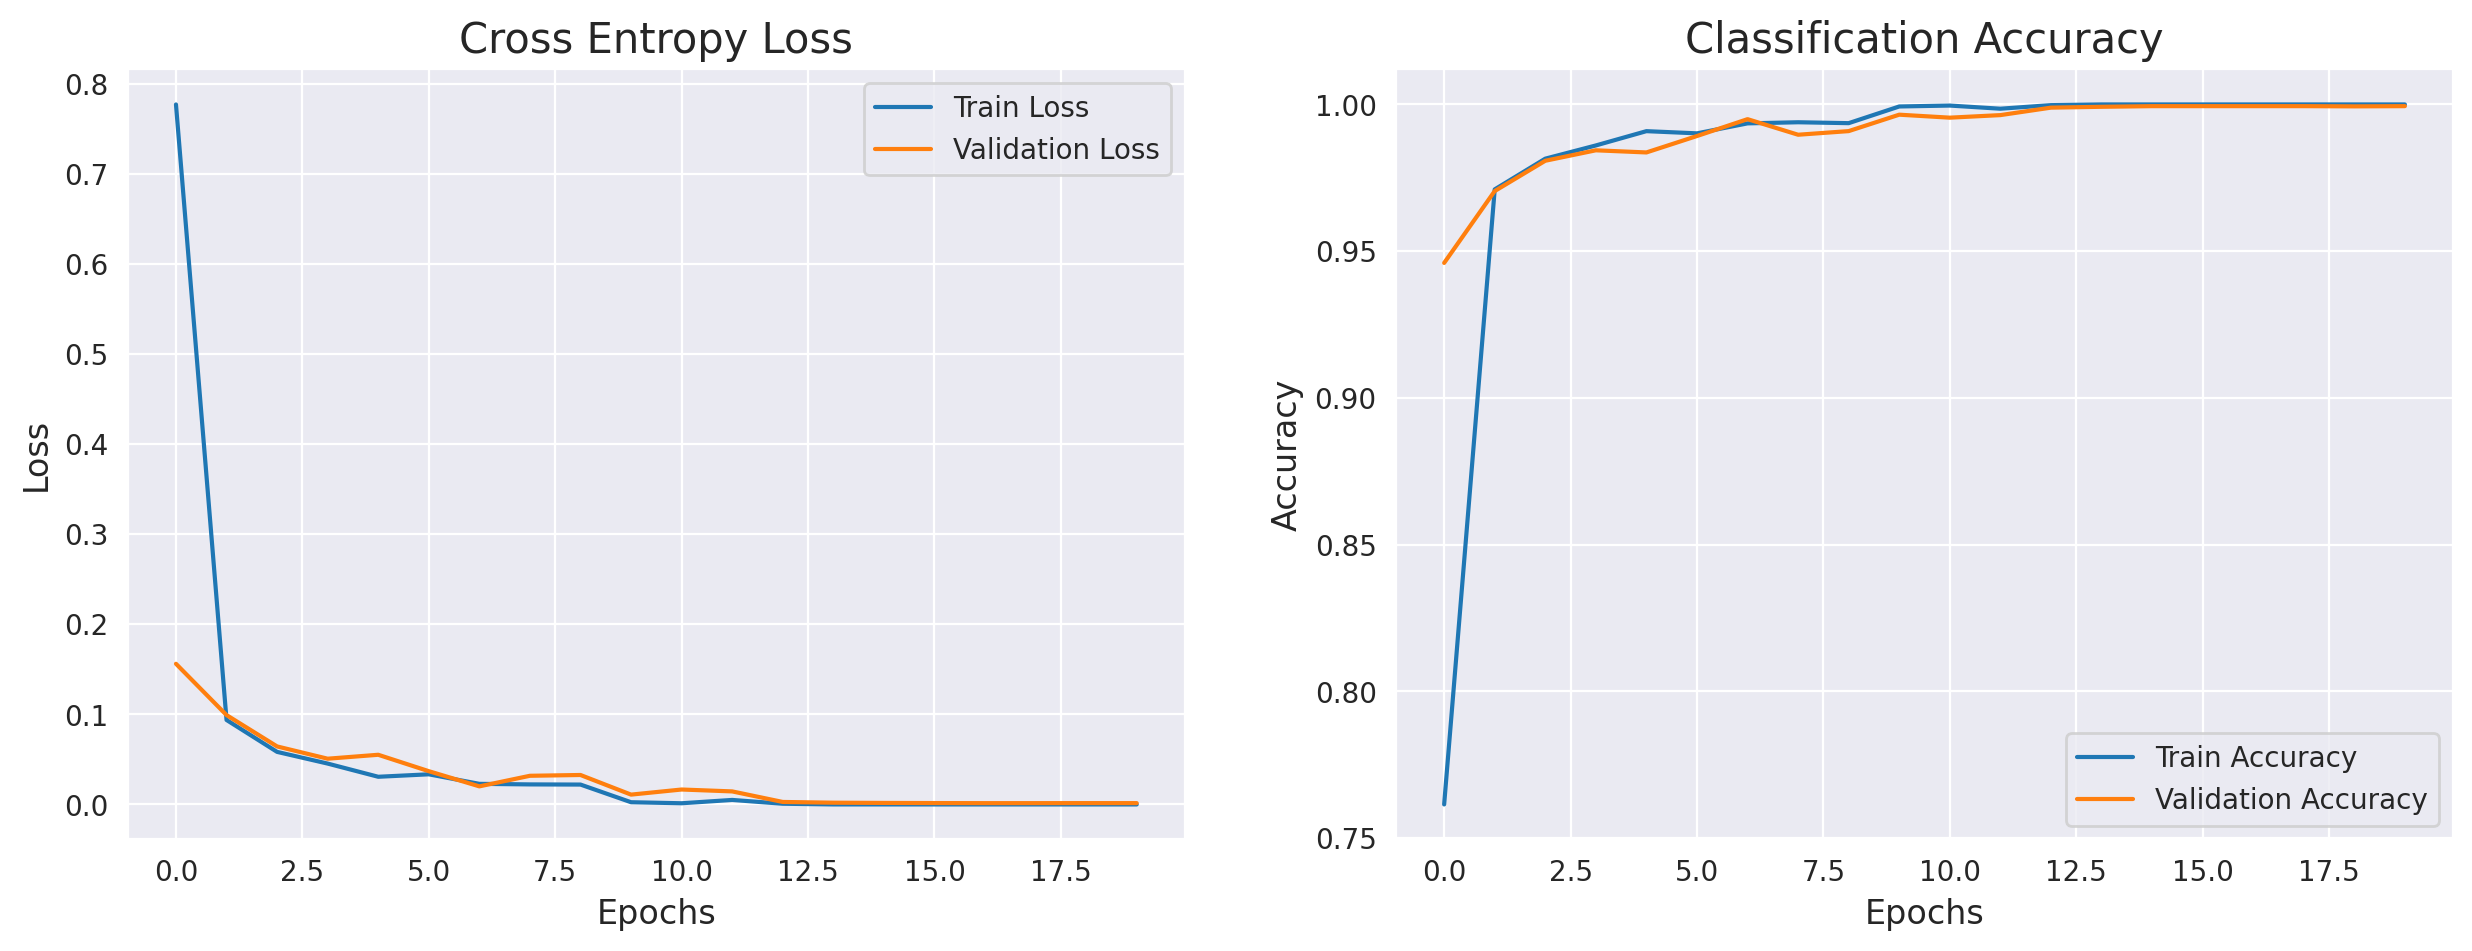

In [ ]:
metrics = pd.DataFrame(cnn_model.history.history)

plt.figure(figsize=(15,5),dpi=200)
sns.set_style('darkgrid')

plt.subplot(121)
plt.title('Cross Entropy Loss',fontsize=15)
plt.xlabel('Epochs',fontsize=12)
plt.ylabel('Loss',fontsize=12)
plt.plot(metrics['loss'], label='Train Loss')
plt.plot(metrics['val_loss'], label='Validation Loss')
plt.legend()

plt.subplot(122)
plt.title('Classification Accuracy',fontsize=15)
plt.xlabel('Epochs',fontsize=12)
plt.ylabel('Accuracy',fontsize=12)
plt.plot(metrics['accuracy'], label='Train Accuracy')
plt.plot(metrics['val_accuracy'], label='Validation Accuracy')
plt.legend()

plt.show()

In [ ]:
# Evaluate test dataset
loss, acc = cnn_model.evaluate(test_gen, verbose=False)

print('The accuracy of the model for testing data is:', acc*100)
print('The Loss of the model for testing data is:', loss)

predicted_class = cnn_model.predict(test_gen, verbose=False)
predicted_class = np.argmax(predicted_class, axis=1)
actual_class = test_gen.labels

correct = np.nonzero(predicted_class == actual_class)[0]
incorrect = np.nonzero(predicted_class != actual_class)[0]

print("Correct predicted classes:", correct.shape[0])
print("Incorrect predicted classes:", incorrect.shape[0])

The accuracy of the model for testing data is: 99.93415474891663
The Loss of the model for testing data is: 0.002302247565239668
Correct predicted classes: 12142
Incorrect predicted classes: 8


In [ ]:
print(classification_report(actual_class, predicted_class,
                            target_names=categories.values()))

              precision    recall  f1-score   support

           A       1.00      1.00      1.00       450
           B       1.00      1.00      1.00       450
           C       1.00      1.00      1.00       450
           D       1.00      1.00      1.00       450
           E       1.00      1.00      1.00       450
           F       1.00      1.00      1.00       450
           G       1.00      1.00      1.00       450
           H       1.00      1.00      1.00       450
           I       1.00      1.00      1.00       450
           J       1.00      1.00      1.00       450
           K       1.00      1.00      1.00       450
           L       1.00      1.00      1.00       450
           M       1.00      1.00      1.00       450
           N       1.00      1.00      1.00       450
           O       1.00      1.00      1.00       450
           P       1.00      1.00      1.00       450
           Q       1.00      1.00      1.00       450
           R       1.00    

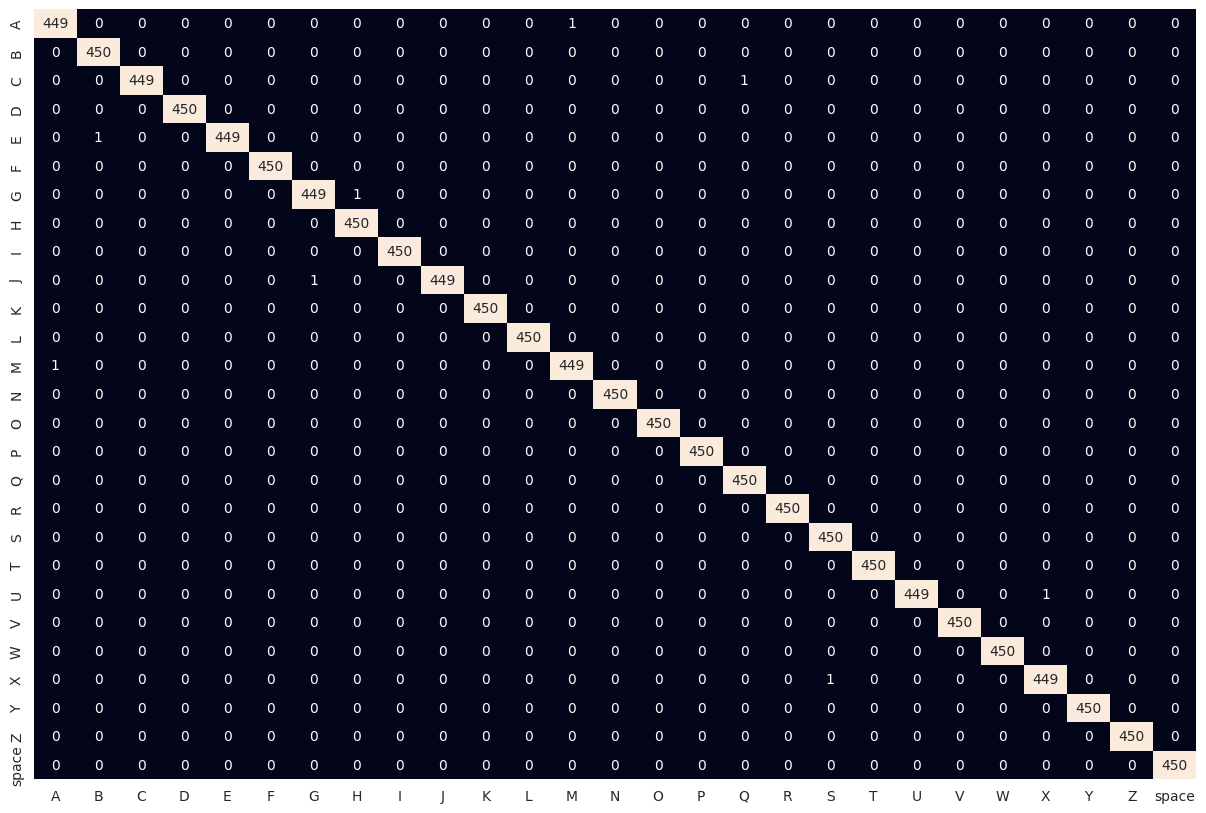

In [ ]:
con_matrix = tf.math.confusion_matrix(
        labels=actual_class,
        predictions=predicted_class,
        num_classes=27)

plt.figure(figsize=(15,10))
sns.heatmap(con_matrix, annot=True, fmt='g', cbar=False, xticklabels=categories.values(), yticklabels=categories.values())
plt.show()

**InceptionV3**

In [ ]:
base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(img_height, img_width, img_channels))

model = Sequential()
model.add(base_model)
model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(27, activation='softmax'))

model.summary()

87910968/87910968 [==============================] - 1s 0us/step
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_v3 (Functional)   (None, 2, 2, 2048)        21802784  
                                                                 
 flatten_2 (Flatten)         (None, 8192)              0         
                                                                 
 dense_6 (Dense)             (None, 512)               4194816   
                                                                 
 dropout_4 (Dropout)         (None, 512)               0         
                                                                 
 dense_7 (Dense)             (None, 512)               262656    
                                                                 
 dropout_5 (Dropout)         (None, 512)               0         
                                                       

In [ ]:
base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(img_height, img_width, img_channels))

for layer in base_model.layers:
    layer.trainable = False

x = base_model.output
x = Flatten()(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(27, activation='softmax')(x)

inceptionV3Model = Model(inputs=base_model.input, outputs=predictions)

display(inceptionV3Model.summary())
# display(tf.keras.utils.plot_model(inceptionV3Model, to_file='inceptionV3.png', show_shapes=True))

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 128, 128, 3)]        0         []                            
                                                                                                  
 conv2d_180 (Conv2D)         (None, 63, 63, 32)           864       ['input_3[0][0]']             
                                                                                                  
 batch_normalization_180 (B  (None, 63, 63, 32)           96        ['conv2d_180[0][0]']          
 atchNormalization)                                                                               
                                                                                                  
 activation_179 (Activation  (None, 63, 63, 32)           0         ['batch_normalization_180[

None

In [ ]:
# Compile and train the model
inceptionV3Model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])
# Train the Model
inceptionV3Model.fit(
    train_gen,
    steps_per_epoch=train_gen.samples // batch_size,
    epochs=epochs,
    validation_data=val_gen,
    validation_steps=val_gen.samples // batch_size,
    callbacks=[checkpoint, early_stopping, reduce_learning_rate],
    verbose=True
)

function ClickConnect(){
  console.log("Working");
  document.querySelector("colab-connect-button").click()
}
setInterval(ClickConnect, 60000)


In [ ]:
inceptionV3Model.save('inceptionV3_model.h5')
! cp inceptionV3_model.h5 /content/gdrive/MyDrive/Models/
! ls /content/gdrive/MyDrive/Models/

asl_vgg16_best_weights.h5  cnn_model.h5  feat_ext.html	inceptionV3_model.h5  vgg16_model7.h5


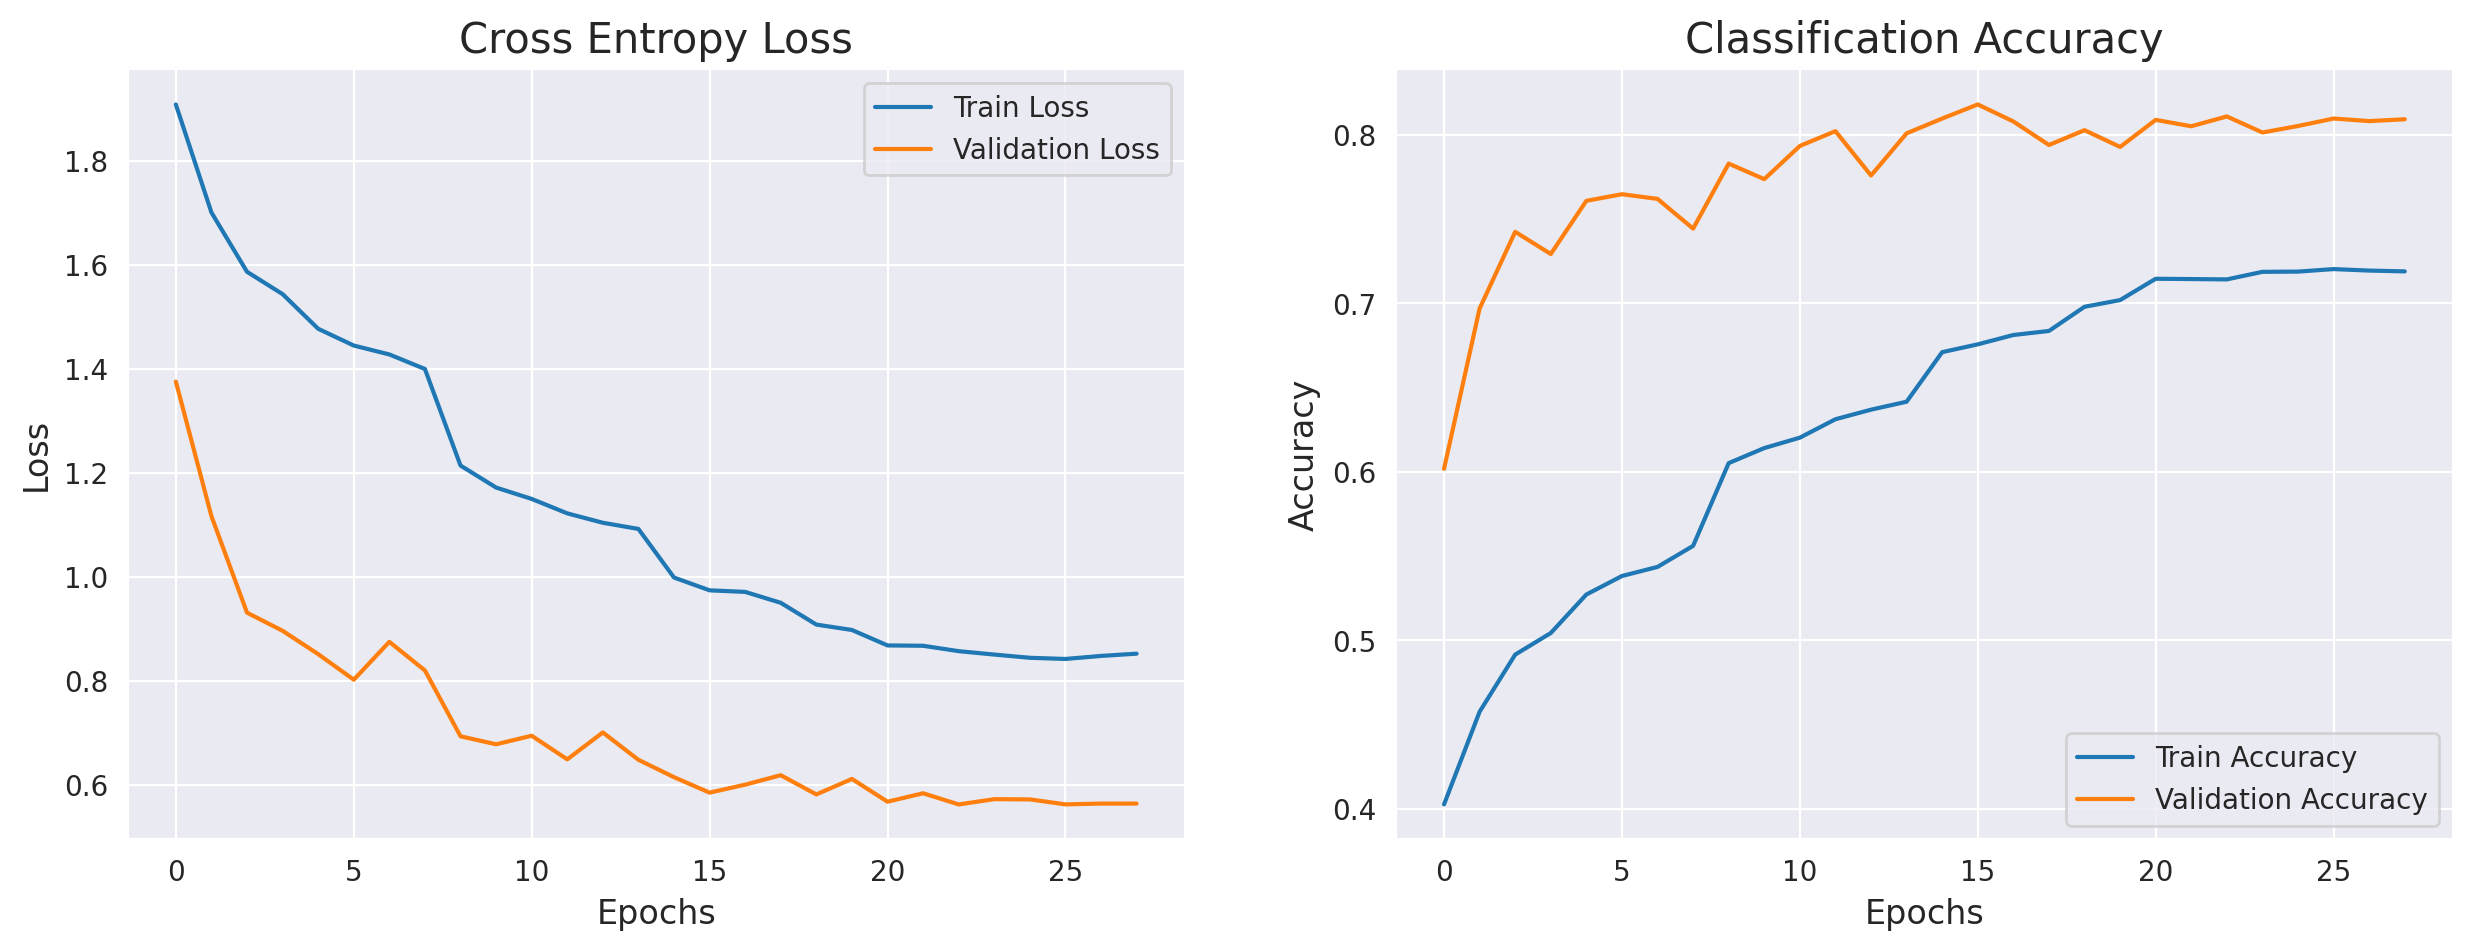

In [ ]:
metrics = pd.DataFrame(inceptionV3Model.history.history)

plt.figure(figsize=(15,5),dpi=200)
sns.set_style('darkgrid')

plt.subplot(121)
plt.title('Cross Entropy Loss',fontsize=15)
plt.xlabel('Epochs',fontsize=12)
plt.ylabel('Loss',fontsize=12)
plt.plot(metrics['loss'], label='Train Loss')
plt.plot(metrics['val_loss'], label='Validation Loss')
plt.legend()

plt.subplot(122)
plt.title('Classification Accuracy',fontsize=15)
plt.xlabel('Epochs',fontsize=12)
plt.ylabel('Accuracy',fontsize=12)
plt.plot(metrics['accuracy'], label='Train Accuracy')
plt.plot(metrics['val_accuracy'], label='Validation Accuracy')
plt.legend()

plt.show()

In [ ]:
# Evaluate test dataset
loss, acc = inceptionV3Model.evaluate(test_gen, verbose=False)

print('The accuracy of the model for testing data is:', acc*100)
print('The Loss of the model for testing data is:', loss)

predicted_class = inceptionV3Model.predict(test_gen, verbose=False)
predicted_class = np.argmax(predicted_class, axis=1)
actual_class = test_gen.labels

correct = np.nonzero(predicted_class == actual_class)[0]
incorrect = np.nonzero(predicted_class != actual_class)[0]

print("Correct predicted classes:", correct.shape[0])
print("Incorrect predicted classes:", incorrect.shape[0])

The accuracy of the model for testing data is: 81.62962794303894
The Loss of the model for testing data is: 0.5618301630020142
Correct predicted classes: 9918
Incorrect predicted classes: 2232


In [ ]:
print(classification_report(actual_class, predicted_class,
                            target_names=categories.values()))

              precision    recall  f1-score   support

           A       0.66      0.91      0.76       450
           B       0.97      0.99      0.98       450
           C       0.99      1.00      1.00       450
           D       0.98      0.99      0.99       450
           E       0.97      0.45      0.61       450
           F       0.99      0.98      0.99       450
           G       0.94      1.00      0.97       450
           H       1.00      0.95      0.98       450
           I       0.70      0.93      0.80       450
           J       1.00      0.98      0.99       450
           K       0.99      0.76      0.86       450
           L       0.82      0.64      0.72       450
           M       0.55      0.98      0.71       450
           N       1.00      0.26      0.42       450
           O       0.98      0.99      0.98       450
           P       0.93      1.00      0.96       450
           Q       1.00      0.95      0.97       450
           R       0.97    

**ResNet**

In [ ]:
base_model = ResNet50V2(weights='imagenet', include_top=False, input_shape=(img_height, img_width, img_channels))

model = Sequential()
model.add(base_model)
model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(27, activation='softmax'))

model.summary()

94668760/94668760 [==============================] - 1s 0us/step
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50v2 (Functional)     (None, 4, 4, 2048)        23564800  
                                                                 
 flatten_3 (Flatten)         (None, 32768)             0         
                                                                 
 dense_9 (Dense)             (None, 512)               16777728  
                                                                 
 dropout_6 (Dropout)         (None, 512)               0         
                                                                 
 dense_10 (Dense)            (None, 512)               262656    
                                                                 
 dropout_7 (Dropout)         (None, 512)               0         
                                                       

In [ ]:
base_model = ResNet50V2(weights='imagenet', include_top=False, input_shape=(img_height, img_width, img_channels))

for layer in base_model.layers:
    layer.trainable = False

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(27, activation='softmax')(x)

resNetModel = Model(inputs=base_model.input, outputs=predictions)

display(resNetModel.summary())
# display(tf.keras.utils.plot_model(inceptionV3Model, to_file='inceptionV3.png', show_shapes=True))

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 128, 128, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 134, 134, 3)          0         ['input_3[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 64, 64, 64)           9472      ['conv1_pad[0][0]']           
                                                                                                  
 pool1_pad (ZeroPadding2D)   (None, 66, 66, 64)           0         ['conv1_conv[0][0]']          
                                                                                            

None

In [ ]:
# Compile and train the model
resNetModel.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])
# Train the Model
resNetModel.fit(
    train_gen,
    steps_per_epoch=train_gen.samples // batch_size,
    epochs=epochs,
    validation_data=val_gen,
    validation_steps=val_gen.samples // batch_size,
    callbacks=[checkpoint, early_stopping, reduce_learning_rate],
    verbose=True
)

In [ ]:
resNetModel.save('resnet_model.h5')
! cp resnet_model.h5 /content/gdrive/MyDrive/Models/
! ls /content/gdrive/MyDrive/Models/

categories.pkl	resnet_model.h5  vgg16_model6.h5  vgg16_model.h5


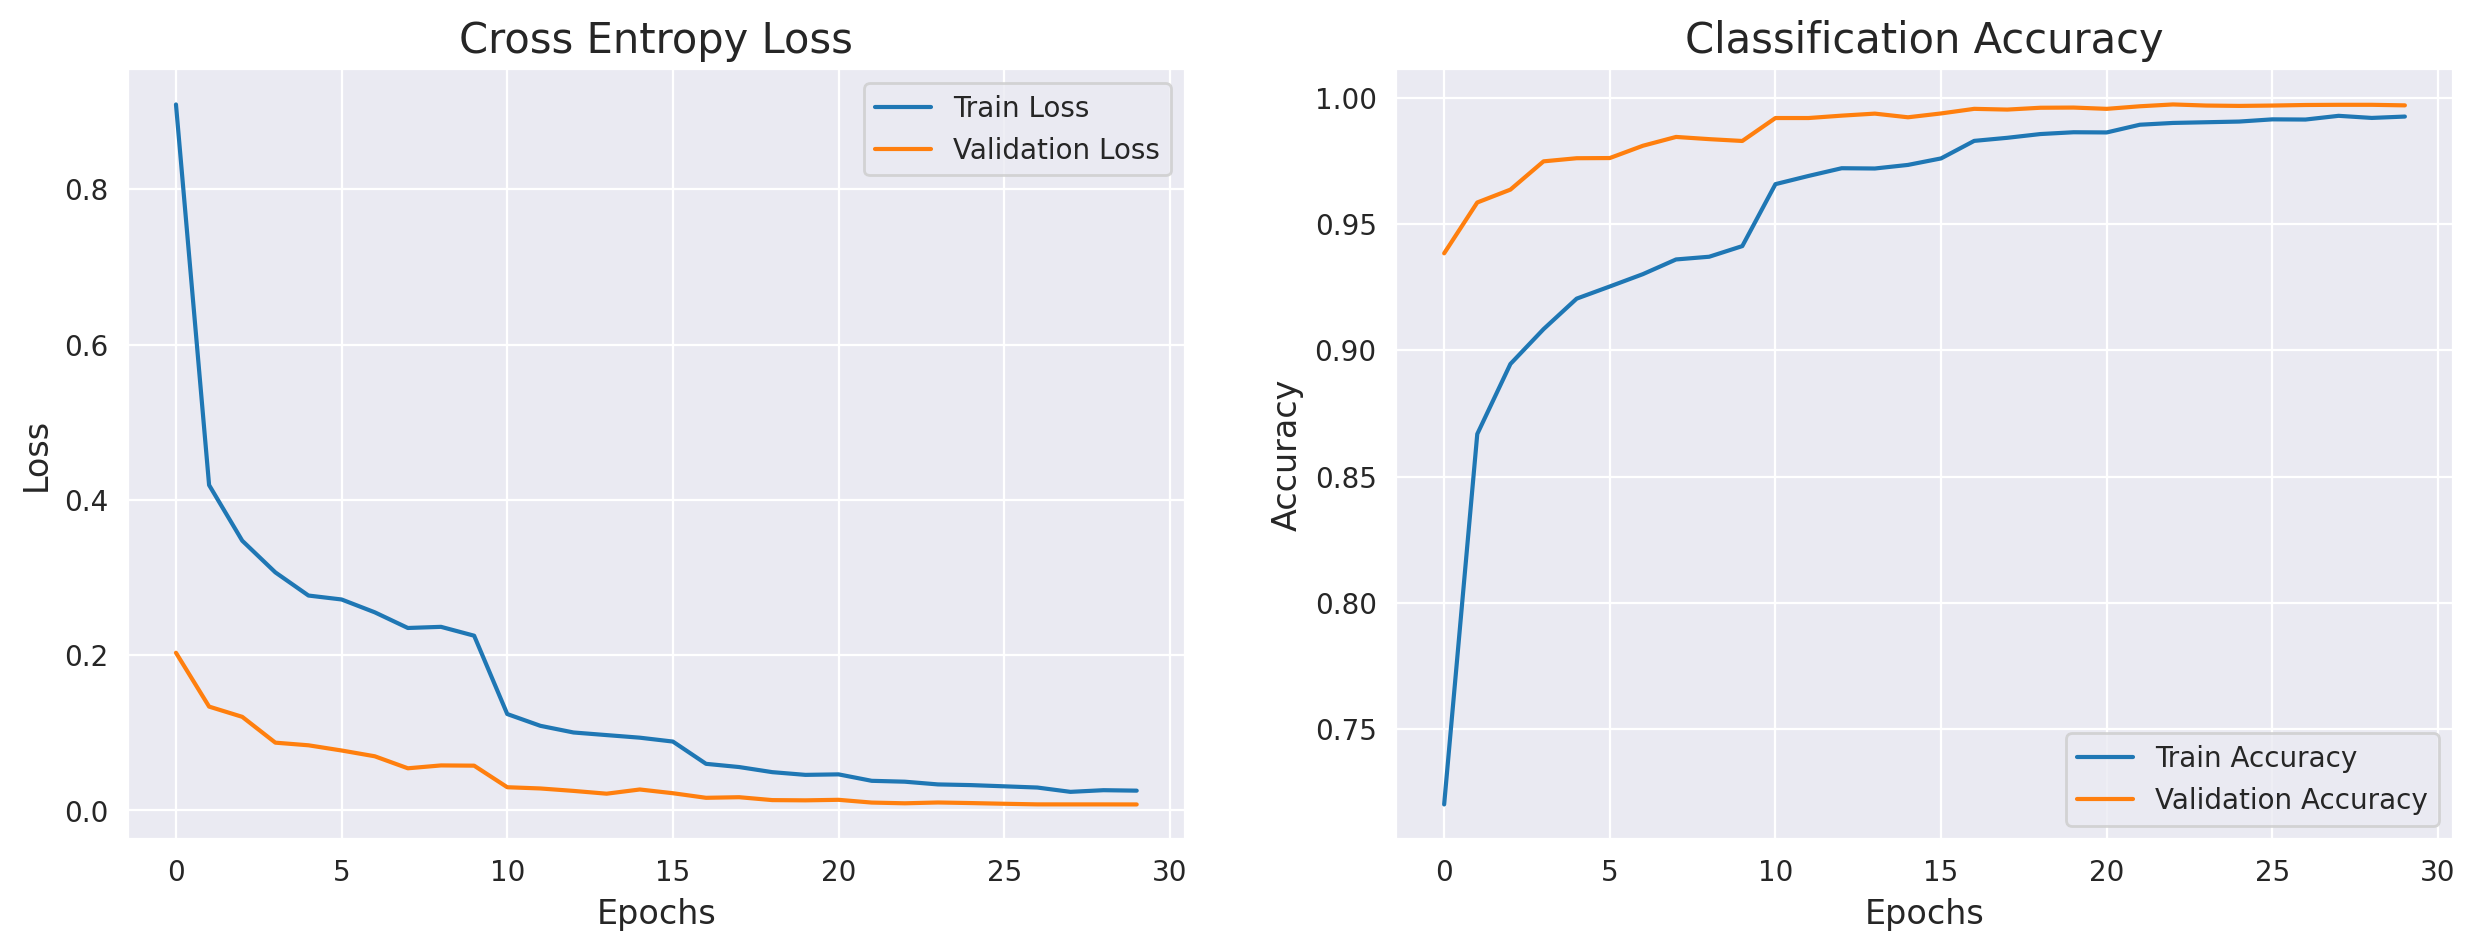

In [ ]:
metrics = pd.DataFrame(resNetModel.history.history)

plt.figure(figsize=(15,5),dpi=200)
sns.set_style('darkgrid')

plt.subplot(121)
plt.title('Cross Entropy Loss',fontsize=15)
plt.xlabel('Epochs',fontsize=12)
plt.ylabel('Loss',fontsize=12)
plt.plot(metrics['loss'], label='Train Loss')
plt.plot(metrics['val_loss'], label='Validation Loss')
plt.legend()

plt.subplot(122)
plt.title('Classification Accuracy',fontsize=15)
plt.xlabel('Epochs',fontsize=12)
plt.ylabel('Accuracy',fontsize=12)
plt.plot(metrics['accuracy'], label='Train Accuracy')
plt.plot(metrics['val_accuracy'], label='Validation Accuracy')
plt.legend()

plt.show()

In [ ]:
# Evaluate test dataset
loss, acc = resNetModel.evaluate(test_gen, verbose=False)

print('The accuracy of the model for testing data is:', acc*100)
print('The Loss of the model for testing data is:', loss)

predicted_class = resNetModel.predict(test_gen, verbose=False)
predicted_class = np.argmax(predicted_class, axis=1)
actual_class = test_gen.labels

correct = np.nonzero(predicted_class == actual_class)[0]
incorrect = np.nonzero(predicted_class != actual_class)[0]

print("Correct predicted classes:", correct.shape[0])
print("Incorrect predicted classes:", incorrect.shape[0])

The accuracy of the model for testing data is: 99.70370531082153
The Loss of the model for testing data is: 0.008748874068260193
Correct predicted classes: 12114
Incorrect predicted classes: 36


In [ ]:
print(classification_report(actual_class, predicted_class,
                            target_names=categories.values()))

              precision    recall  f1-score   support

           A       1.00      1.00      1.00       450
           B       1.00      1.00      1.00       450
           C       1.00      1.00      1.00       450
           D       1.00      1.00      1.00       450
           E       1.00      1.00      1.00       450
           F       1.00      1.00      1.00       450
           G       1.00      1.00      1.00       450
           H       1.00      1.00      1.00       450
           I       0.99      1.00      1.00       450
           J       1.00      1.00      1.00       450
           K       1.00      0.99      1.00       450
           L       1.00      1.00      1.00       450
           M       0.99      1.00      1.00       450
           N       1.00      0.99      1.00       450
           O       1.00      1.00      1.00       450
           P       1.00      0.99      1.00       450
           Q       0.99      1.00      1.00       450
           R       0.98    

**DenseNet**

In [ ]:
base_model = DenseNet121(weights='imagenet', include_top=False, input_shape=(img_height, img_width, img_channels))

model = Sequential()
model.add(base_model)
model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(27, activation='softmax'))

model.summary()

29084464/29084464 [==============================] - 0s 0us/step
Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 densenet121 (Functional)    (None, 4, 4, 1024)        7037504   
                                                                 
 flatten_4 (Flatten)         (None, 16384)             0         
                                                                 
 dense_12 (Dense)            (None, 512)               8389120   
                                                                 
 dropout_8 (Dropout)         (None, 512)               0         
                                                                 
 dense_13 (Dense)            (None, 512)               262656    
                                                                 
 dropout_9 (Dropout)         (None, 512)               0         
                                                       

In [ ]:
base_model = DenseNet121(weights='imagenet', include_top=False, input_shape=(img_height, img_width, img_channels))

for layer in base_model.layers:
    layer.trainable = False

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(27, activation='softmax')(x)

denseNetModel = Model(inputs=base_model.input, outputs=predictions)

display(denseNetModel.summary())
# display(tf.keras.utils.plot_model(inceptionV3Model, to_file='inceptionV3.png', show_shapes=True))

29084464/29084464 [==============================] - 0s 0us/step
Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_4 (InputLayer)        [(None, 128, 128, 3)]        0         []                            
                                                                                                  
 zero_padding2d (ZeroPaddin  (None, 134, 134, 3)          0         ['input_4[0][0]']             
 g2D)                                                                                             
                                                                                                  
 conv1/conv (Conv2D)         (None, 64, 64, 64)           9408      ['zero_padding2d[0][0]']      
                                                                                                  
 conv1/bn (BatchNormalizati

None

In [ ]:
# Compile and train the model
denseNetModel.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])
# Train the Model
denseNetModel.fit(
    train_gen,
    steps_per_epoch=train_gen.samples // batch_size,
    epochs=epochs,
    validation_data=val_gen,
    validation_steps=val_gen.samples // batch_size,
    callbacks=[checkpoint, early_stopping, reduce_learning_rate],
    verbose=True
)

In [ ]:
denseNetModel.save('densenet_model.h5')
! cp densenet_model.h5 /content/gdrive/MyDrive/Models/
! ls /content/gdrive/MyDrive/Models/

categories.pkl	densenet_model.h5  resnet_model.h5  vgg16_model6.h5  vgg16_model.h5


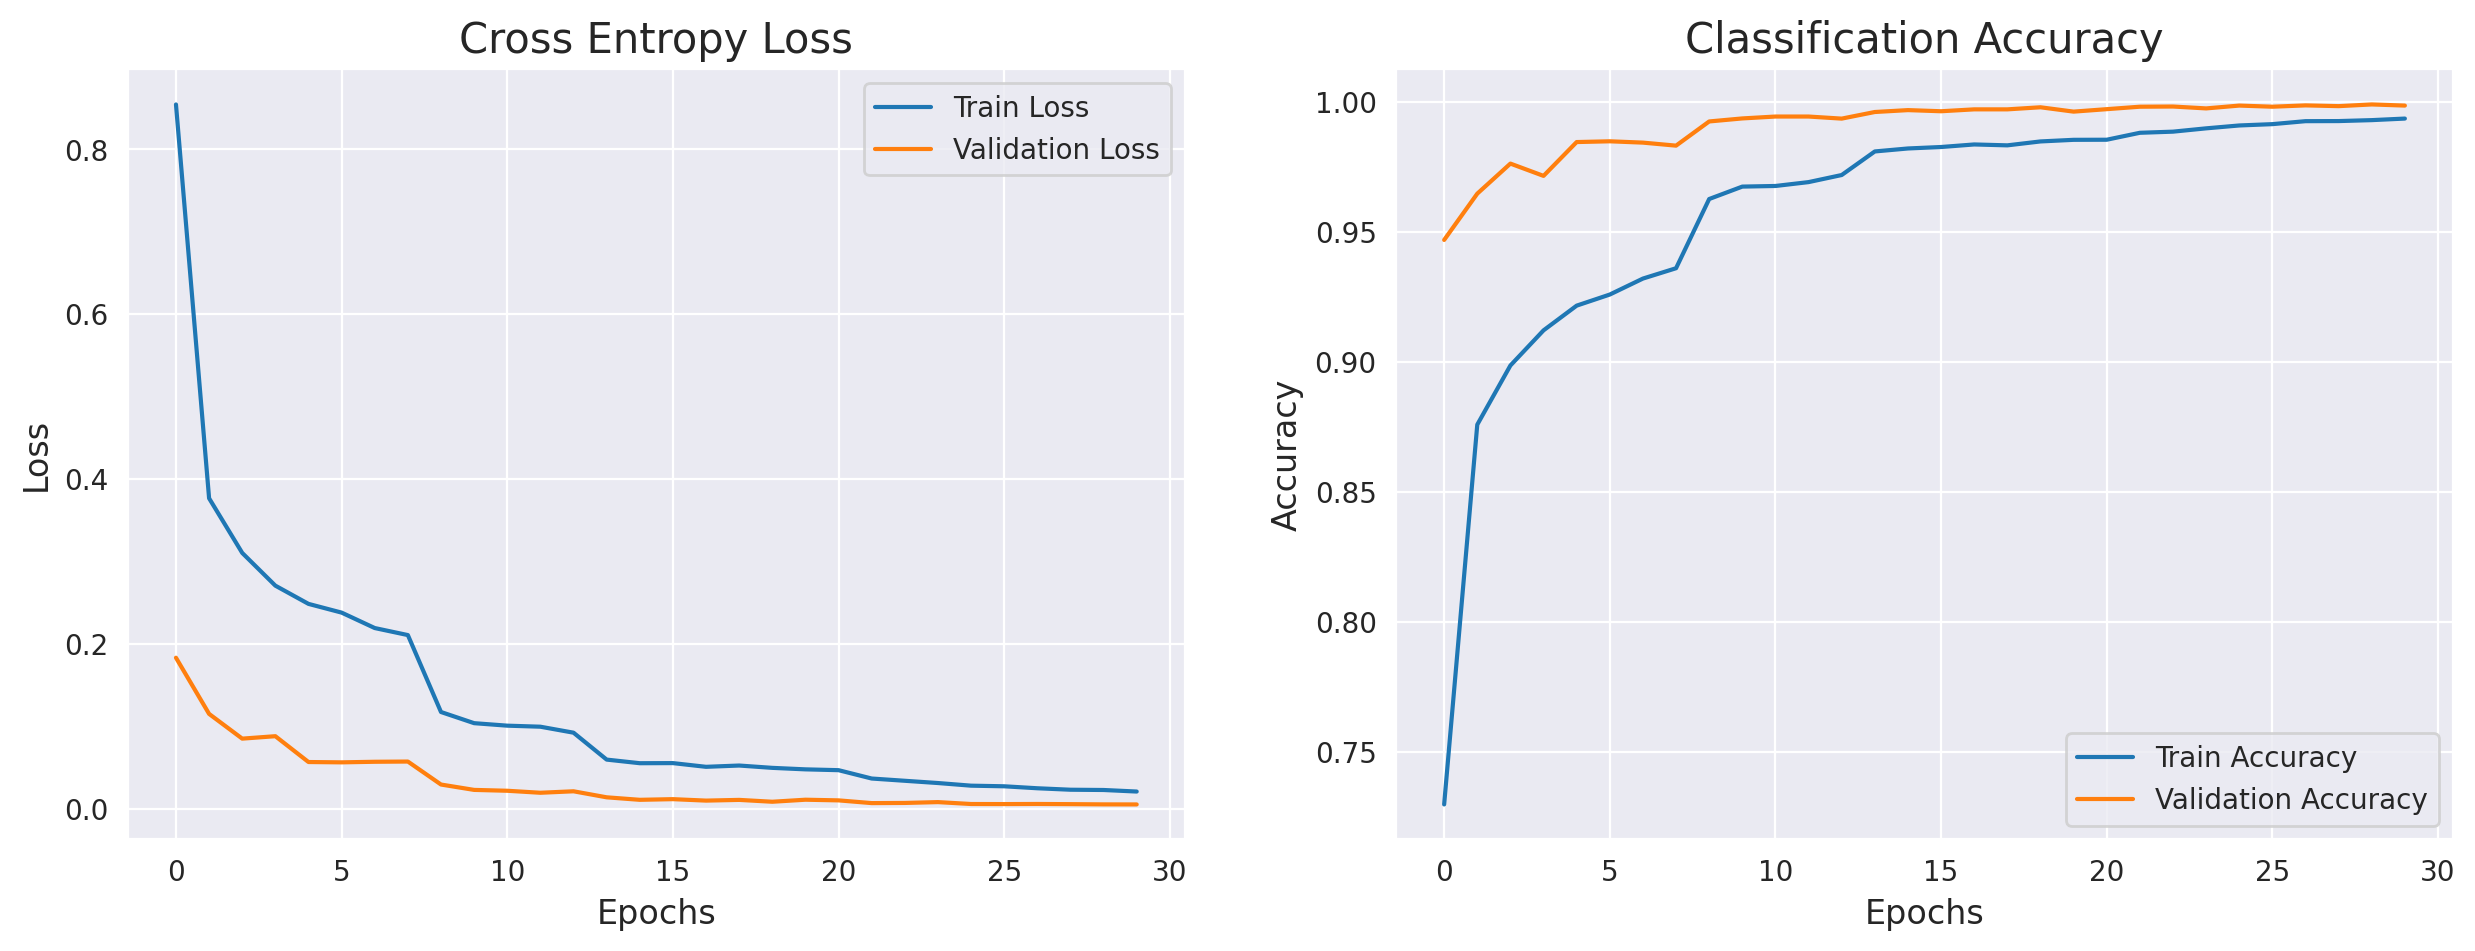

In [ ]:
metrics = pd.DataFrame(denseNetModel.history.history)

plt.figure(figsize=(15,5),dpi=200)
sns.set_style('darkgrid')

plt.subplot(121)
plt.title('Cross Entropy Loss',fontsize=15)
plt.xlabel('Epochs',fontsize=12)
plt.ylabel('Loss',fontsize=12)
plt.plot(metrics['loss'], label='Train Loss')
plt.plot(metrics['val_loss'], label='Validation Loss')
plt.legend()

plt.subplot(122)
plt.title('Classification Accuracy',fontsize=15)
plt.xlabel('Epochs',fontsize=12)
plt.ylabel('Accuracy',fontsize=12)
plt.plot(metrics['accuracy'], label='Train Accuracy')
plt.plot(metrics['val_accuracy'], label='Validation Accuracy')
plt.legend()

plt.show()

In [ ]:
# Evaluate test dataset
loss, acc = denseNetModel.evaluate(test_gen, verbose=False)

print('The accuracy of the model for testing data is:', acc*100)
print('The Loss of the model for testing data is:', loss)

predicted_class = denseNetModel.predict(test_gen, verbose=False)
predicted_class = np.argmax(predicted_class, axis=1)
actual_class = test_gen.labels

correct = np.nonzero(predicted_class == actual_class)[0]
incorrect = np.nonzero(predicted_class != actual_class)[0]

print("Correct predicted classes:", correct.shape[0])
print("Incorrect predicted classes:", incorrect.shape[0])

The accuracy of the model for testing data is: 99.80247020721436
The Loss of the model for testing data is: 0.006620797328650951
Correct predicted classes: 12126
Incorrect predicted classes: 24


In [ ]:
print(classification_report(actual_class, predicted_class,
                            target_names=categories.values()))

              precision    recall  f1-score   support

           A       1.00      1.00      1.00       450
           B       1.00      1.00      1.00       450
           C       1.00      1.00      1.00       450
           D       1.00      1.00      1.00       450
           E       1.00      1.00      1.00       450
           F       1.00      1.00      1.00       450
           G       1.00      1.00      1.00       450
           H       1.00      1.00      1.00       450
           I       1.00      1.00      1.00       450
           J       1.00      1.00      1.00       450
           K       1.00      1.00      1.00       450
           L       1.00      1.00      1.00       450
           M       1.00      1.00      1.00       450
           N       1.00      1.00      1.00       450
           O       1.00      0.99      1.00       450
           P       1.00      1.00      1.00       450
           Q       1.00      1.00      1.00       450
           R       0.99    

**Custom CNN**

In [ ]:
custModel = Sequential()

custModel.add(Conv2D(64, (3, 3), padding='same', input_shape=(128,128, 3), activation='relu'))
custModel.add(MaxPool2D(pool_size=(2, 2)))
custModel.add(BatchNormalization())

custModel.add(Conv2D(128, (3, 3), padding='same', activation='relu'))
custModel.add(MaxPool2D(pool_size=(2, 2)))
custModel.add(BatchNormalization())
custModel.add(Dropout(0.2))

custModel.add(Conv2D(256, (3, 3), padding='same', activation='relu'))
custModel.add(MaxPool2D(pool_size=(2, 2)))
custModel.add(BatchNormalization())

custModel.add(Flatten())
custModel.add(Dense(1024, activation='relu'))
custModel.add(Dropout(0.2))
custModel.add(Dense(27, activation='softmax'))

custModel.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 128, 128, 64)      1792      
                                                                 
 max_pooling2d (MaxPooling2  (None, 64, 64, 64)        0         
 D)                                                              
                                                                 
 batch_normalization (Batch  (None, 64, 64, 64)        256       
 Normalization)                                                  
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 64, 128)       73856     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 32, 32, 128)       0         
 g2D)                                                            
                                                        

In [ ]:
# Compile and train the model
custModel.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])
# Train the Model
custModel.fit(
    train_gen,
    steps_per_epoch=train_gen.samples // batch_size,
    epochs=epochs,
    validation_data=val_gen,
    validation_steps=val_gen.samples // batch_size,
    callbacks=[checkpoint, early_stopping, reduce_learning_rate],
    verbose=True
)

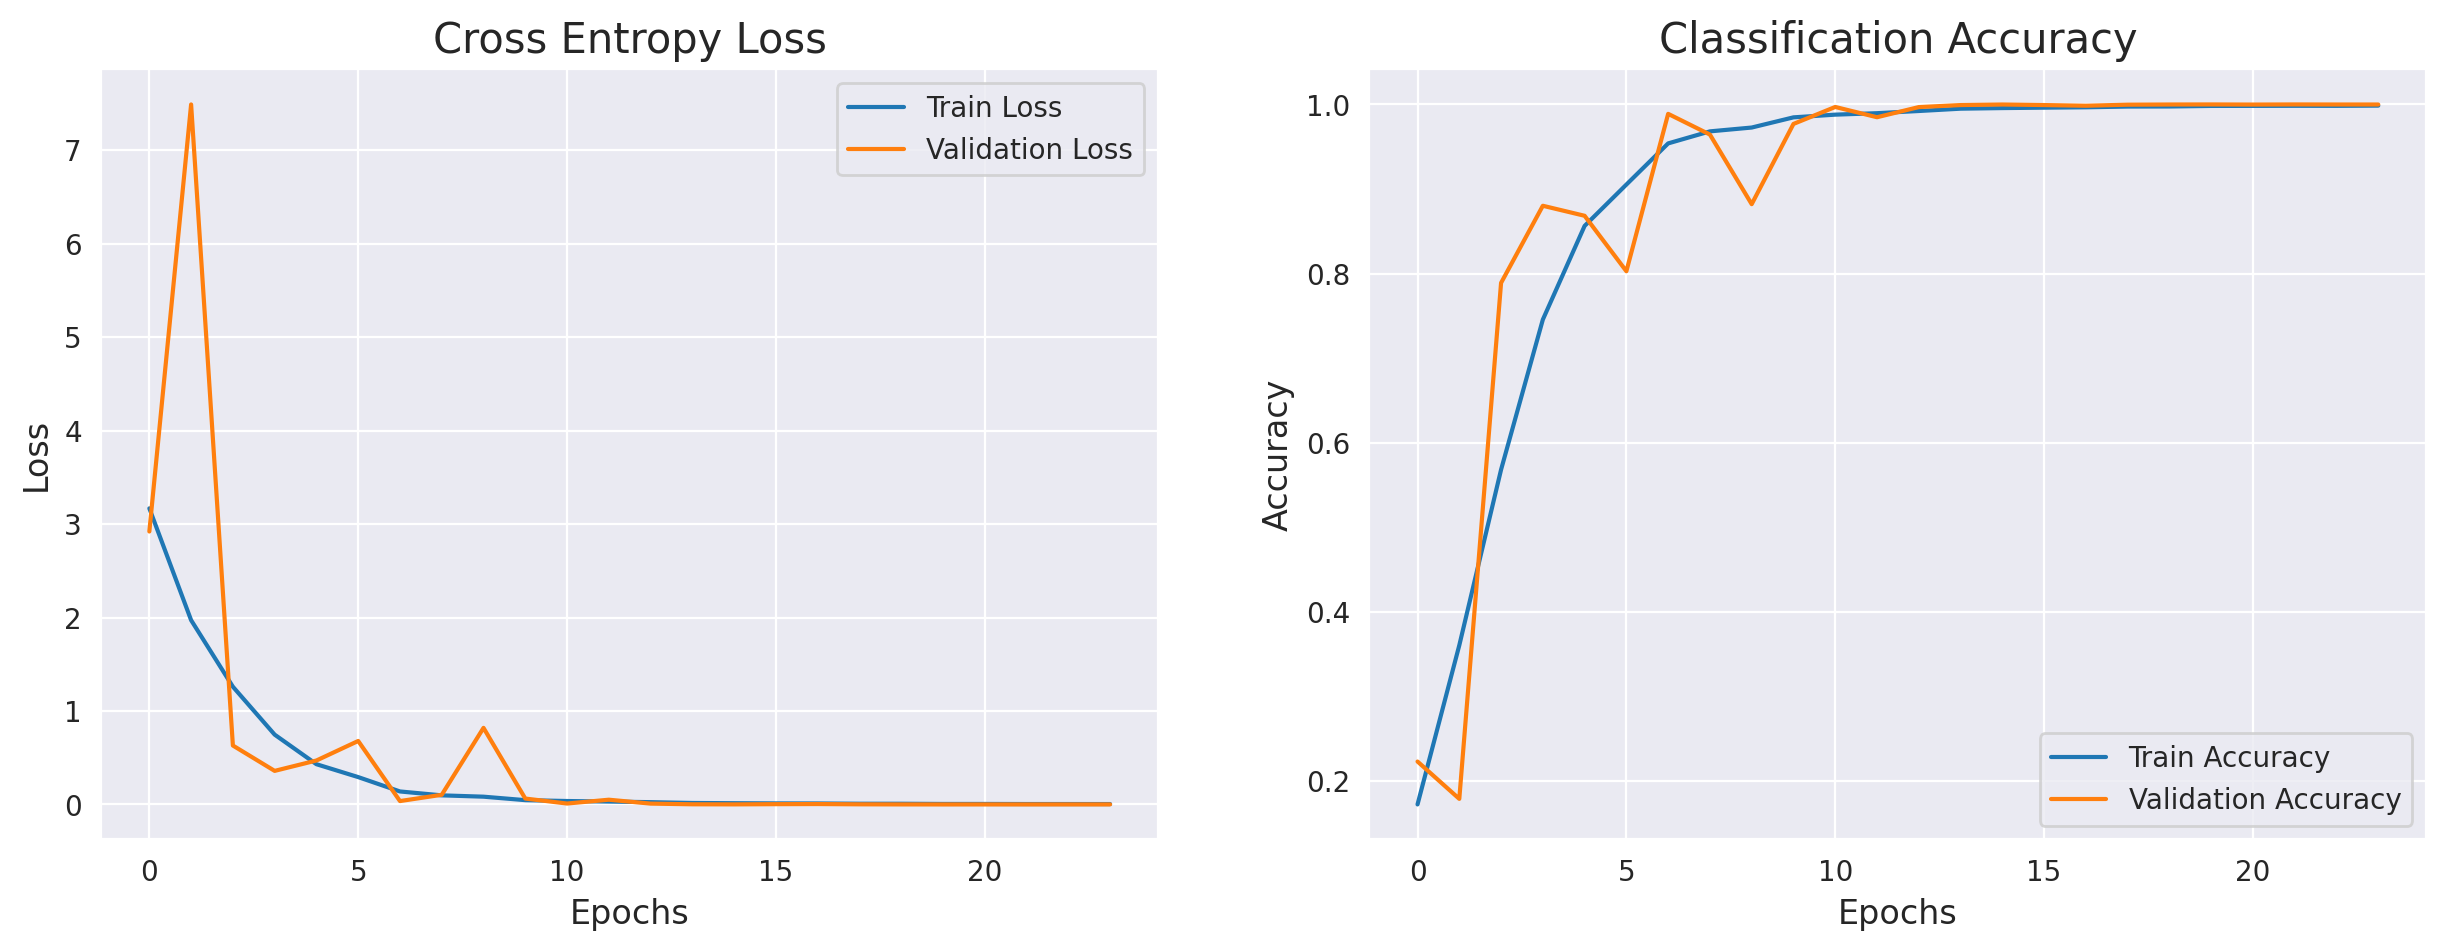

In [ ]:
metrics = pd.DataFrame(custModel.history.history)

plt.figure(figsize=(15,5),dpi=200)
sns.set_style('darkgrid')

plt.subplot(121)
plt.title('Cross Entropy Loss',fontsize=15)
plt.xlabel('Epochs',fontsize=12)
plt.ylabel('Loss',fontsize=12)
plt.plot(metrics['loss'], label='Train Loss')
plt.plot(metrics['val_loss'], label='Validation Loss')
plt.legend()

plt.subplot(122)
plt.title('Classification Accuracy',fontsize=15)
plt.xlabel('Epochs',fontsize=12)
plt.ylabel('Accuracy',fontsize=12)
plt.plot(metrics['accuracy'], label='Train Accuracy')
plt.plot(metrics['val_accuracy'], label='Validation Accuracy')
plt.legend()

plt.show()

In [ ]:
# Evaluate test dataset
loss, acc = custModel.evaluate(test_gen, verbose=False)

print('The accuracy of the model for testing data is:', acc*100)
print('The Loss of the model for testing data is:', loss)

predicted_class = custModel.predict(test_gen, verbose=False)
predicted_class = np.argmax(predicted_class, axis=1)
actual_class = test_gen.labels

correct = np.nonzero(predicted_class == actual_class)[0]
incorrect = np.nonzero(predicted_class != actual_class)[0]

print("Correct predicted classes:", correct.shape[0])
print("Incorrect predicted classes:", incorrect.shape[0])

The accuracy of the model for testing data is: 99.97530579566956
The Loss of the model for testing data is: 0.00097813387401402
Correct predicted classes: 12147
Incorrect predicted classes: 3


In [ ]:
print(classification_report(actual_class, predicted_class,
                            target_names=categories.values()))

              precision    recall  f1-score   support

           A       1.00      1.00      1.00       450
           B       1.00      1.00      1.00       450
           C       1.00      1.00      1.00       450
           D       1.00      1.00      1.00       450
           E       1.00      1.00      1.00       450
           F       1.00      1.00      1.00       450
           G       1.00      1.00      1.00       450
           H       1.00      1.00      1.00       450
           I       1.00      1.00      1.00       450
           J       1.00      1.00      1.00       450
           K       1.00      1.00      1.00       450
           L       1.00      1.00      1.00       450
           M       1.00      1.00      1.00       450
           N       1.00      1.00      1.00       450
           O       1.00      1.00      1.00       450
           P       1.00      1.00      1.00       450
           Q       1.00      1.00      1.00       450
           R       1.00    

In [ ]:
custModel.save('custcnn_model_new1.h5')
! cp custcnn_model_new1.h5 /content/gdrive/MyDrive/Models/
! ls /content/gdrive/MyDrive/Models/

asl_model  cnn_large_model.h5  custcnn_model_new1.h5  custcnn_model_new.h5


In [ ]:
print("Done :)")

Done :)
